In [16]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
from scipy.optimize import brentq
from scipy.stats import binom

In [2]:
# Load cached data
!wget -nv -O ../data/imagenet/human_readable_labels.json -L https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json
data = np.load('../data/imagenet/imagenet-resnet152.npz')
example_paths = os.listdir('../data/imagenet/examples')
smx = data['smx']
labels = data['labels'].astype(int)

2022-08-29 08:16:29 URL:https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json [14193/14193] -> "../data/imagenet/human_readable_labels.json" [1]


In [128]:
# Problem setup
n=1000 # number of calibration points
alpha = 0.1 # 1-alpha is the desired selective accuracy
delta = 0.1 # delta is the failure rate

In [129]:
# Split the softmax scores into calibration and validation sets (save the shuffling)
idx = np.array([1] * n + [0] * (smx.shape[0]-n)) > 0
np.random.shuffle(idx)
cal_smx, val_smx = smx[idx,:], smx[~idx,:]
cal_labels, val_labels = labels[idx], labels[~idx]
# Yhat, Phat
cal_yhats = np.argmax(cal_smx,axis=1)
cal_phats = cal_smx.max(axis=1)

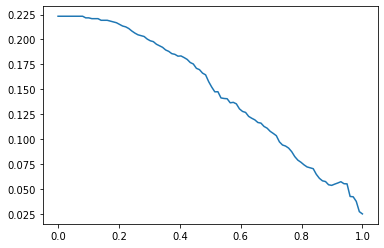

In [137]:
# Define selective risk
def selective_risk(lam): return (cal_yhats[cal_phats >= lam] != cal_labels[cal_phats >= lam]).sum()/(cal_phats >= lam).sum()
def nlambda(lam): return (cal_phats >= lam).sum()
def invert_for_ub(r,lam): return binom.cdf(selective_risk(lam)*nlambda(lam),nlambda(lam),r)-delta
def selective_risk_ub(lam): return brentq(invert_for_ub,0,0.9999,args=(lam,))


In [6]:
# Calculate empirical coverage
empirical_coverage = prediction_sets[np.arange(prediction_sets.shape[0]),val_labels].mean()
print(f"The empirical coverage is: {empirical_coverage}")

The empirical coverage is: 0.8916530612244898


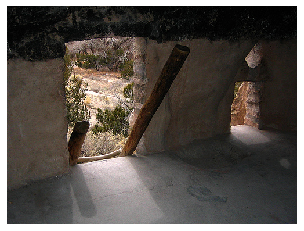

The prediction set is: ['cliff dwelling', 'hammer', 'hatchet']


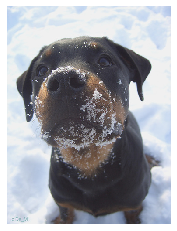

The prediction set is: ['Rottweiler', 'Dobermann']


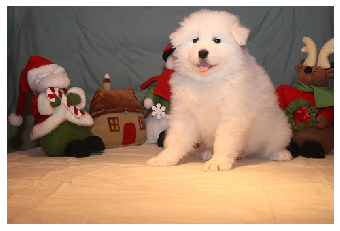

The prediction set is: ['Samoyed']


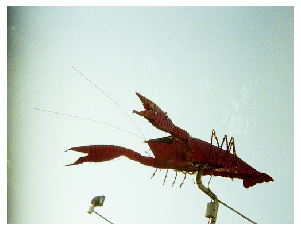

The prediction set is: ['crayfish', 'cockroach']


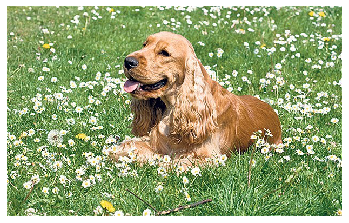

The prediction set is: ['Cocker Spaniels', 'Sussex Spaniel']


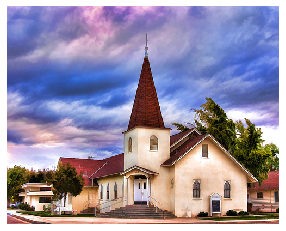

The prediction set is: ['church']


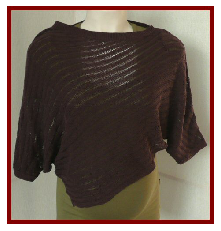

The prediction set is: ['poncho']


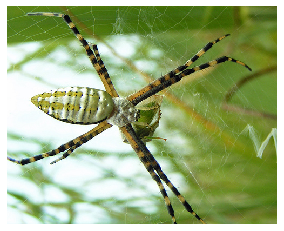

The prediction set is: ['yellow garden spider', 'European garden spider']


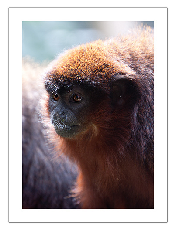

The prediction set is: ['titi']


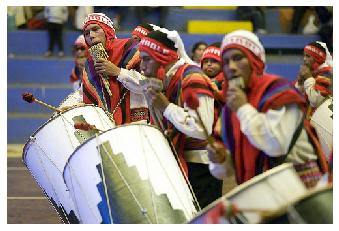

The prediction set is: ['drum', 'pan flute', 'steel drum']


In [7]:
# Show some examples
with open('../data/imagenet/human_readable_labels.json') as f:
    label_strings = np.array(json.load(f))

example_paths =os.listdir('../data/imagenet/examples')
for i in range(10):
    rand_path = np.random.choice(example_paths)
    img = imread('../data/imagenet/examples/' + rand_path )
    img_index = int(rand_path.split('.')[0])
    prediction_set = smx[img_index] > 1-qhat
    plt.figure()
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    print(f"The prediction set is: {list(label_strings[prediction_set])}")